# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.logging.set_verbosity(tf.logging.INFO)

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Exploratory Data Analysis 

In [2]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


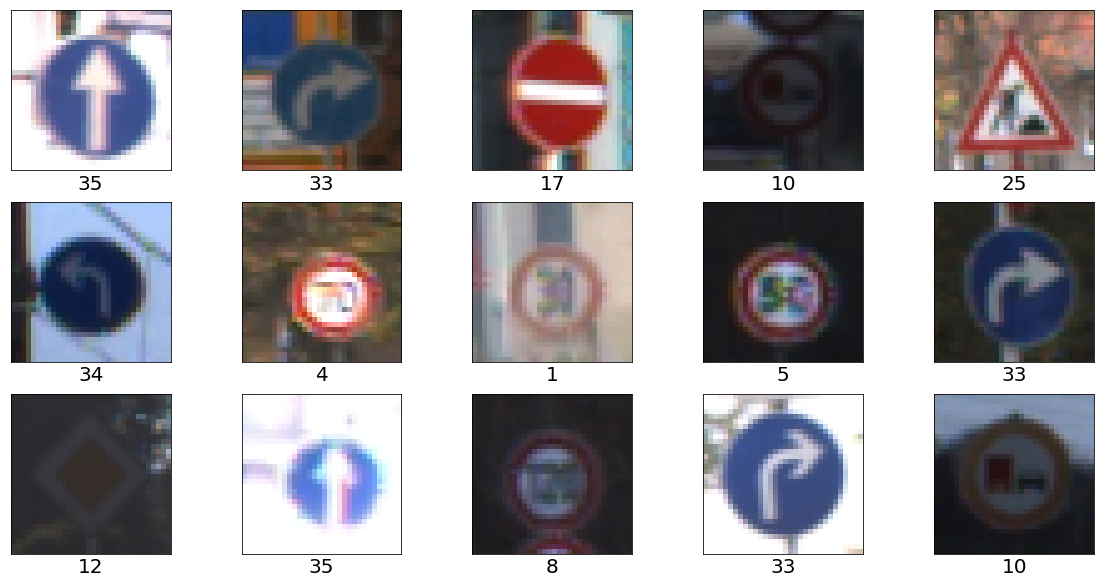

In [3]:
random_indices = np.random.randint(0, n_train, size=15)
plt.figure(figsize=(20,10))
for i, index in enumerate(random_indices, start=1):
    plt.subplot(3, 5, i)
    plt.tick_params(axis='both', which='both', bottom='off', labelbottom='off',
                    left='off', labelleft='off')
    plt.xlabel(y_train[index], color='black', fontsize=20)
    plt.imshow(X_train[index])

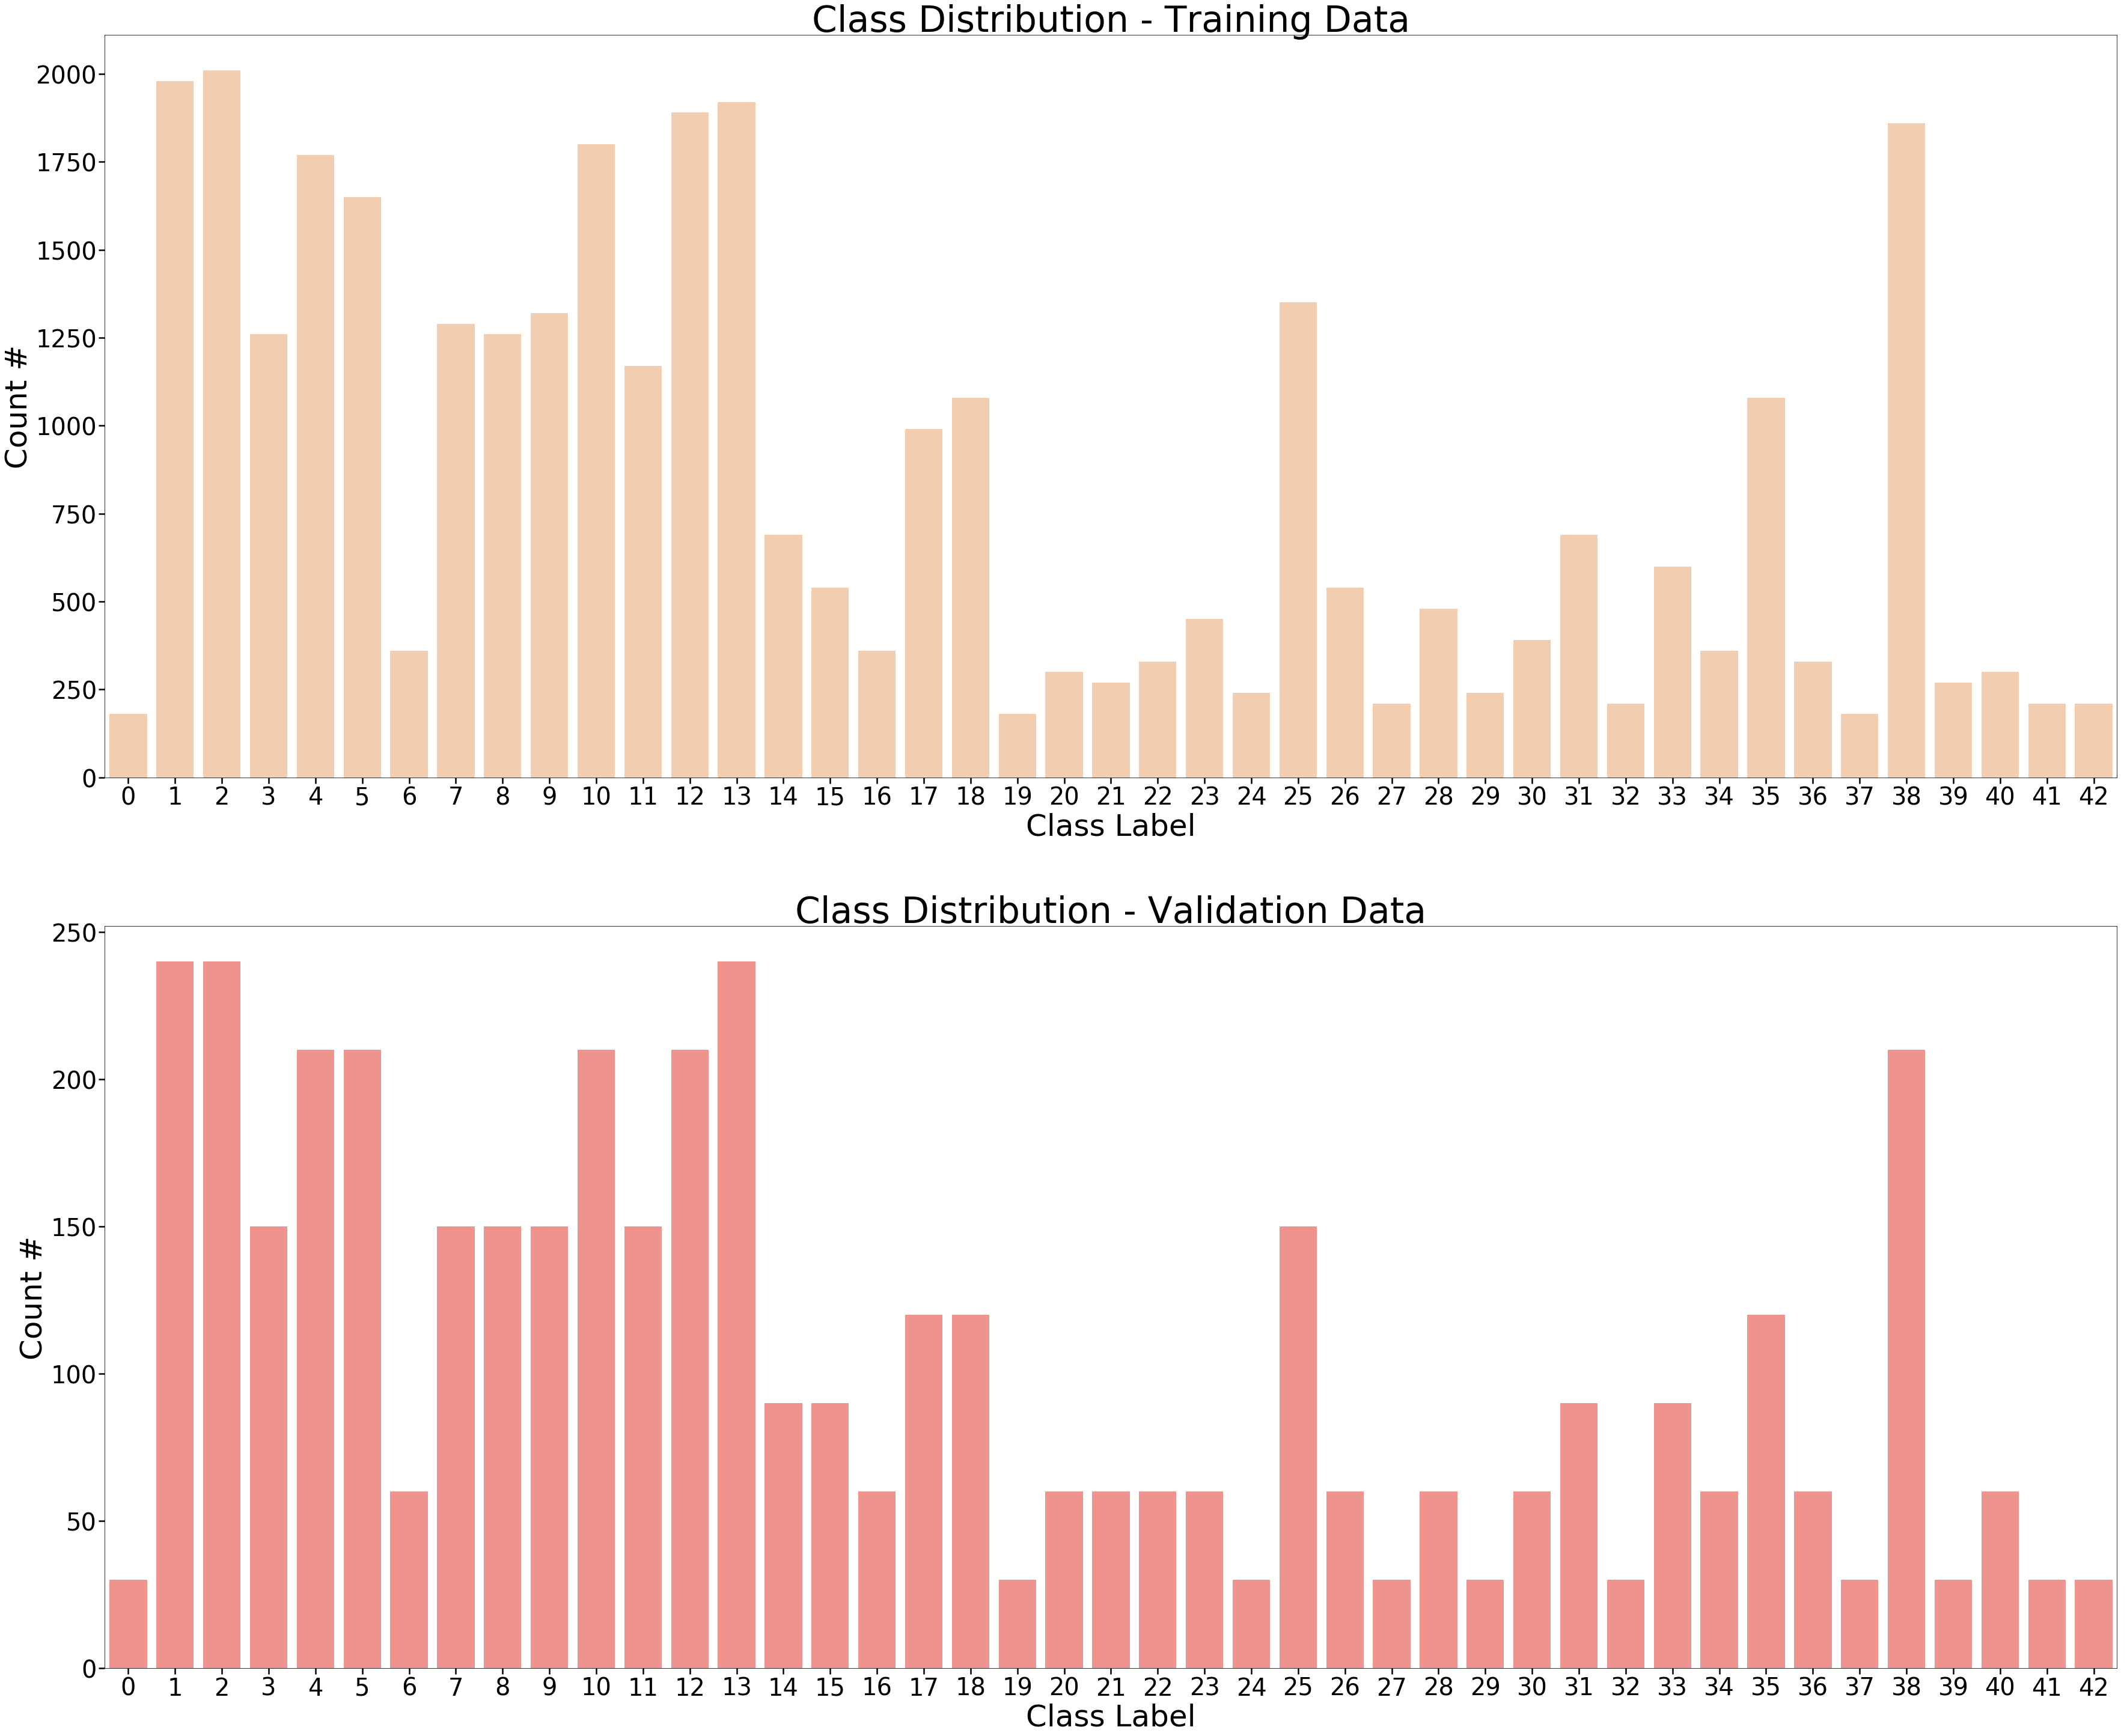

In [4]:
plt.figure(figsize=(60,50))

class_counts_train = np.unique(y_train, return_counts=True)
plt.subplot(2, 1, 1)
plt.title('Class Distribution - Training Data', fontsize=60)
plt.ylabel('Count #', fontsize=50)
plt.xlabel('Class Label', fontsize=50)
plt.tick_params(axis='both', which='both', length=10, width=2.5, labelsize=40)
sns.barplot(x=class_counts_train[0], y=class_counts_train[1], color='#FFCCA3')

class_counts_valid = np.unique(y_valid, return_counts=True)
plt.subplot(2, 1, 2)
plt.title('Class Distribution - Validation Data', fontsize=60)
plt.ylabel('Count #', fontsize=50)
plt.xlabel('Class Label', fontsize=50)
plt.tick_params(axis='both', which='both', length=10, width=2.5, labelsize=40)
sns.barplot(x=class_counts_valid[0], y=class_counts_valid[1], color='#FF847E')

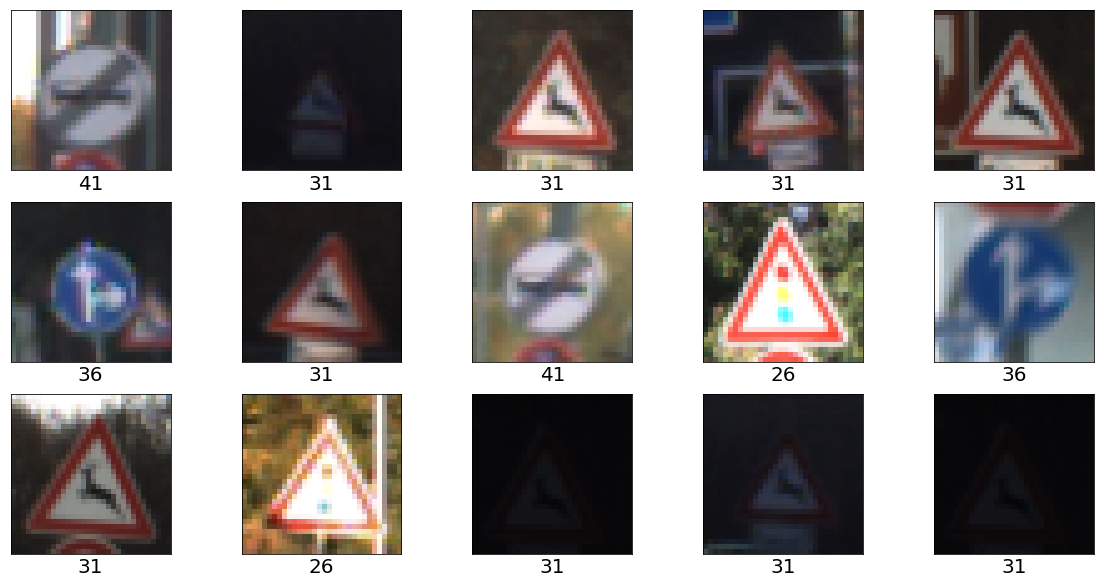

In [5]:
under_250_classes = class_counts_train[0][class_counts_train[1] < 250]
under_250_indices = np.where(np.isin(y_train, under_250_classes))[0]
random_indices = np.random.randint(0, len(under_250_indices), size=15)

plt.figure(figsize=(20,10))
for i, index in enumerate(random_indices, start=1):
    plt.subplot(3, 5, i)
    plt.tick_params(axis='both', which='both', bottom='off', labelbottom='off',
                    left='off', labelleft='off')
    plt.xlabel(y_train[index], color='black', fontsize=20)
    plt.imshow(X_train[index])

----

## Create Estimator

In [6]:
scaled_X_train = (X_train/255.).astype(np.float32)
scaled_X_valid = (X_valid/255.).astype(np.float32)
scaled_X_test = (X_test/255.).astype(np.float32)

In [7]:
hot_y_train = keras.utils.to_categorical(y_train).astype(np.float32)
hot_y_valid = keras.utils.to_categorical(y_valid).astype(np.float32)
hot_y_test = keras.utils.to_categorical(y_test).astype(np.float32)

In [8]:
image_input = keras.layers.Input(shape=(32,32,3))
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(32,32,3), name='input')(image_input)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Conv2D(128, 3, padding='same', activation='relu', name='block2_conv')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.Conv2D(256, 3, padding='same', activation='relu', name='block3_conv')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
x = keras.layers.Dense(256, activation='relu', name='block4_fc')(x)
x = keras.layers.BatchNormalization(momentum=0.9)(x)
output = keras.layers.Dense(43, activation='softmax')(x)

model = keras.Model(inputs=image_input, outputs=output)

In [9]:
early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.0025, patience=2, mode='min')

In [10]:
num_models = 10
model_weights = []
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for i in range(num_models):
    print('\n-----------Training Model #{}-----------\n'.format(i))
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(scaled_X_train, hot_y_train, batch_size=64, epochs=20,
                        verbose=1, validation_data=(scaled_X_valid, hot_y_valid),
                        callbacks=[early_stopping])
    model_weights.append(model.get_weights())
    train_acc.append(history.history['acc'][-1])
    train_loss.append(history.history['loss'][-1])
    val_acc.append(history.history['val_acc'][-1])
    val_loss.append(history.history['val_loss'][-1])


-----------Training Model #0-----------

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================]34799/34799 [==============================] - 10s 301us/step - loss: 0.4596 - acc: 0.8765 - val_loss: 0.3027 - val_acc: 0.9116

Epoch 2/20
34799/34799 [==============================]34799/34799 [==============================] - 9s 247us/step - loss: 0.0360 - acc: 0.9901 - val_loss: 0.1906 - val_acc: 0.9333

Epoch 3/20
34799/34799 [==============================]34799/34799 [==============================] - 8s 241us/step - loss: 0.0265 - acc: 0.9930 - val_loss: 0.3494 - val_acc: 0.9043

Epoch 4/20
34799/34799 [==============================]34799/34799 [==============================] - 9s 248us/step - loss: 0.0269 - acc: 0.9922 - val_loss: 0.1309 - val_acc: 0.9624

Epoch 5/20
34799/34799 [======

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================]34799/34799 [==============================] - 9s 269us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.2531 - val_acc: 0.9624

Epoch 2/20
34799/34799 [==============================]34799/34799 [==============================] - 8s 242us/step - loss: 0.0027 - acc: 0.9992 - val_loss: 0.1223 - val_acc: 0.9735

Epoch 3/20
34799/34799 [==============================]34799/34799 [==============================] - 8s 241us/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.1790 - val_acc: 0.9701

Epoch 4/20
34799/34799 [==============================]34799/34799 [==============================] - 8s 241us/step - loss: 0.0051 - acc: 0.9986 - val_loss: 0.1330 - val_acc: 0.9769


-----------Training Model #9-----------

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================]34799/34799 [==============================] - 9s 271us/step - loss: 0.00

In [11]:
model.set_weights(np.average(model_weights, axis=0))

In [12]:
val_loss, val_acc = model.evaluate(scaled_X_valid, hot_y_valid, verbose=1, batch_size=256)
print('Validation Loss: {}\nValidation Accuracy: {}'.format(val_loss, val_acc))

4410/4410 [==============================]4410/4410 [==============================] - 0s 65us/step

Validation Loss: 0.09574573797019634
Validation Accuracy: 0.9795918367346939


# SUBMISSION REVIEWER - PLEASE REVIEW THIS SECTION & PROVIDE INFO ON WHY THIS MAY NOT BE TRAINING PROPERLY

In [ ]:
num_epochs = 10
batch_size = 64
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'input': scaled_X_train},
    y=hot_y_train,
    shuffle=True,
    batch_size=batch_size,
    num_epochs=num_epochs,
    num_threads=1
)

valid_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'input': scaled_X_valid},
    y=hot_y_valid,
    shuffle=False,
    batch_size=batch_size,
    num_epochs=1,
    num_threads=1
)

### Model Architecture

In [ ]:
def model_fn(features, labels, mode, params):
    
    # Input layer
    input_layer = tf.cast(features['input'], tf.float32)
    
    # First convolution block
    block1_conv = tf.layers.conv2d(input_layer, 64, kernel_size=3, strides=1, padding='same',
                                   activation=tf.nn.relu, name='block1_conv1')
    block1_conv = tf.layers.batch_normalization(block1_conv, name='block1_conv1_bn')
    block1_pool = tf.layers.max_pooling2d(block1_conv, pool_size=2, strides=2, padding='valid',
                                          name='block1_pool')
    
    #Second convolution block
    block2_conv = tf.layers.conv2d(block1_pool, 128, kernel_size=3, strides=1, padding='same',
                                   activation=tf.nn.relu, name='block2_conv2')
    block2_conv = tf.layers.batch_normalization(block2_conv, name='block2_conv2_bn')
    block2_pool = tf.layers.max_pooling2d(block2_conv, pool_size=2, strides=2, padding='valid',
                                          name='block2_pool')
    
    # Second convolution block
    block3_conv = tf.layers.conv2d(block2_pool, 256, kernel_size=3, strides=1, padding='same',
                                   activation=tf.nn.relu, name='block3_conv1')
    block3_conv = tf.layers.conv2d(block3_conv, 256, kernel_size=3, strides=1, padding='same',
                                   activation=tf.nn.relu, name='block3_conv2')
    block3_pool = tf.layers.max_pooling2d(block3_conv, pool_size=2, strides=2, padding='valid',
                                          name='block3_pool')

    # Flatten layer
    flatten = tf.layers.flatten(block1_pool, name='flatten')

    # Fully-connected layers
    fc1 = tf.layers.dense(flatten, 256, activation=tf.nn.relu, name='fc1')    
    fc2 = tf.layers.dense(fc1, 256, activation=tf.nn.relu, name='fc2')
    
    # Output layer
    logits = tf.layers.dense(fc2, n_classes, activation=tf.nn.relu, name='output')
    
    predictions = {
        'classes': tf.argmax(input=logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    # Return predictions if argument passed
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(params['learning_rate'])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Return metrics if in evaluation mode
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=labels, predictions=predictions)
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Train, Validate and Test the Model

In [ ]:
my_estimator = tf.estimator.Estimator(model_fn, params={'learning_rate': 0.001})

In [ ]:
experiment_fn = tf.contrib.learn.Experiment(
    my_estimator,
    train_input_fn,
    eval_input_fn=valid_input_fn,
    min_eval_frequency=500
)

In [ ]:
experiment_fn.train_and_evaluate()

# END OF SPECIAL REVIEW REQUEST

---

## Test Model on New Images from Google

### Load and Output the Images

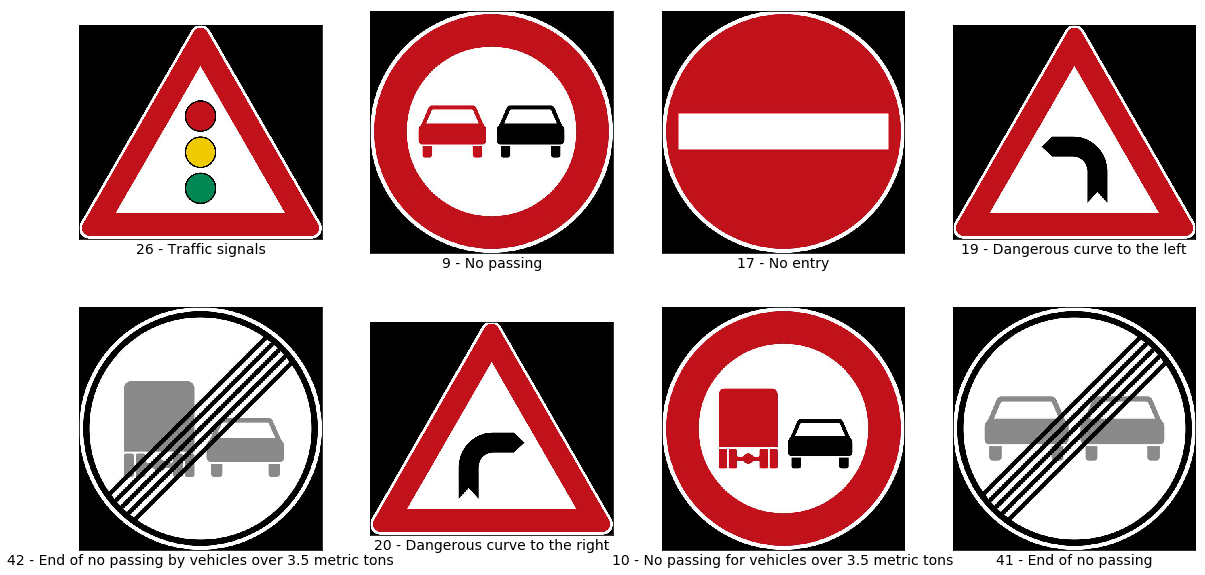

In [13]:
import os
image_files = [os.path.join('examples/', file) for file in os.listdir('examples')]
picture_classes = ['26 - Traffic signals', '9 - No passing', '17 - No entry',
                   '19 - Dangerous curve to the left', 
                   '42 - End of no passing by vehicles over 3.5 metric tons',
                   '20 - Dangerous curve to the right',
                   '10 - No passing for vehicles over 3.5 metric tons',
                   '41 - End of no passing']
plt.figure(figsize=(20,10))
for i, file in enumerate(image_files, start=1):
    plt.subplot(2, 4, i)
    plt.tick_params(axis='both', which='both', bottom='off', labelbottom='off',
                    left='off', labelleft='off')
    plt.xlabel(picture_classes[i-1], color='black', fontsize=14)
    plt.imshow(plt.imread(file))

### Predictions

In [14]:
import cv2
np_images = np.array([cv2.resize(plt.imread(file), (32,32)) for file in image_files])
probabilities = model.predict(np_images/255.)
predictions = probabilities.argmax(axis=-1)

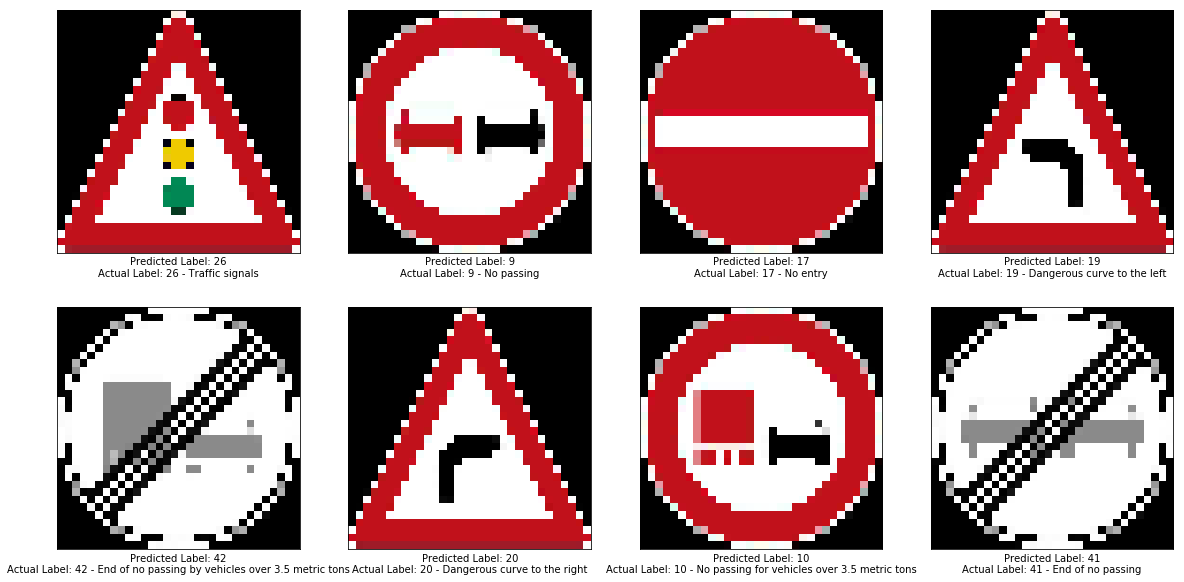

In [15]:
plt.figure(figsize=(20,10))
for i, image in enumerate(np_images, start=1):
    plt.subplot(2, 4, i)
    plt.tick_params(axis='both', which='both', bottom='off', labelbottom='off',
                    left='off', labelleft='off')
    plt.xlabel('Predicted Label: {}\nActual Label: {}'.format(predictions[i-1], picture_classes[i-1]),
               color='black', fontsize=10)
    plt.imshow(image)

The model has 100% accuracy on the five new images of perfect signs.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [16]:
top_5_predictions = [array[:5] for array in np.argsort(-probabilities)]
for i, top_predictions in enumerate(top_5_predictions):
    print('\n-----Top 5 Predictions for Class: {}\n'.format(picture_classes[i]))
    for j, prediction in enumerate(top_predictions, start=1):
        print('(#{})\tClass: {}\t Prob: {}'.format(j, prediction, probabilities[i][prediction]))


-----Top 5 Predictions for Class: 26 - Traffic signals

(#1)	Class: 26	 Prob: 0.9999290704727173
(#2)	Class: 18	 Prob: 3.792053394136019e-05
(#3)	Class: 11	 Prob: 2.4288125132443383e-05
(#4)	Class: 19	 Prob: 3.776734502025647e-06
(#5)	Class: 12	 Prob: 3.4606598546815803e-06

-----Top 5 Predictions for Class: 9 - No passing

(#1)	Class: 9	 Prob: 0.971549391746521
(#2)	Class: 11	 Prob: 0.012368247844278812
(#3)	Class: 41	 Prob: 0.011175278574228287
(#4)	Class: 12	 Prob: 0.0018259144853800535
(#5)	Class: 40	 Prob: 0.001685693277977407

-----Top 5 Predictions for Class: 17 - No entry

(#1)	Class: 17	 Prob: 0.9995453953742981
(#2)	Class: 1	 Prob: 0.00018270300643052906
(#3)	Class: 0	 Prob: 0.0001452882424928248
(#4)	Class: 19	 Prob: 6.827242759754881e-05
(#5)	Class: 26	 Prob: 1.7795138774090447e-05

-----Top 5 Predictions for Class: 19 - Dangerous curve to the left

(#1)	Class: 19	 Prob: 0.9999971389770508
(#2)	Class: 23	 Prob: 9.156354963124613e-07
(#3)	Class: 9	 Prob: 8.174972663255176e-

# **Classify Traffic Signs** 

## Project Goal

---

The goal of this project was to design and implement a convolutional neural network that can identify 43 different types of German traffic signs. It was implemented using Google's [TensorFlow](https://www.tensorflow.org/versions/r1.5/get_started/) and its [Keras package](https://www.tensorflow.org/versions/r1.5/api_docs/python/tf/keras).


[//]: # (Image References)

[training_images]: ./documentation_images/training_images.png "15 traffic signs from the training data"
[valid_dist]: ./documentation_images/valid_distribution.png "Class distributions for the training and validation data sets"
[small_dist]: ./documentation_images/small_distribution.png "Classes that are not prevalant in the data"
[vgg16]: ./documentation_images/imagenet_vgg16.png "VGG16 architecture visualization"
[orig_signs]: ./documentation_images/eight_signs.png "Eight German traffic signs"
[results]: ./documentation_images/signs.png "Eight German traffic sign predictions"
[probs]: ./documentation_images/probs.png "Top 5 probabilities for each German sign"

---

### Data Set Summary & Exploration


Every image in this variation of the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) consists of three channels (RGB) and has a size of 32x32 pixels. There are 51,839 images total, which are divided into three different sets for training, validation, and testing.

| Data Set       | # of Images   |
| :------------- |:-------------:|
| Training       | 34,799        |
| Validation     | 4,410         |   
| Test           | 12,630        |

An image can belong to one of 43 different types of traffic signs. To provide a better idea of what the traffic sign types, here is a snippet of fifteen training images (the number below an image is the class ID).

![alt text][training_images]

Next, by looking at the class distributions, we can clearly see it is not uniform in the training data. However, when we look at the validation data, we can clearly see that the sampling distribution mirrors that of the training data.

![alt text][valid_dist]

Thus, no data augmentation was pursued since the training data would be able to accurately reflect the validation set. Nevertheless, I was interested in seeing what types of images were not prevalent in the data (as shown below). 

![alt text][small_dist]

That these traffic signs do not form a large portion of the data set is not suprising, given that some of the most common traffic signs are for speed limits.

---

### Model Architecture

![alt text][vgg16]

The model architecture I designed was inspired by the famous VGG16 deep neural network architecture from the ILSVRC-2014 competition. In general, VGG16 inspired architectures can be characterized as placing greater emphasis on layer depth (as the image moves forward through the network blocks) than width. Furthermore, within each network block, you typically see multiple convolutions or dense layers with the same dimensions.

In the case of my architecture, I did not follow this "consecutive" pattern in the first two layers and reduced the overall size of the neural network since I trained the model on a far smaller corpus than ImageNet, which the complete VGG16 architecture is trained upon.  I did include two copies of the convolutional layers and two of the dense layers within the last two blocks since I wanted the training to focus on the higher-level features that distinguish one sign from another.  The architecture also utilizes batch normalization to improve training speed and reduce overfitting.

**Final model architecture:**

| Layer         		|     Description	        					| Activation | Output Dimensions |
| :-------------------- |:---------------------------------------------:|:----------:|:-----------------:| 
| Input         		| 32x32x3 RGB image   							| RELU       | 32x32x3           |
| 3x3 Convolution     	| 1x1 stride w/ same padding                	|            | 32x32x64          |
| Batch norm			| Momentum: 0.9, Epsilon: 0.001					|            | 32x32x64          |
| 2x2 Max pooling	    | 2x2 stride w/ valid padding                   |            | 16x16x64          |
| 3x3 Convolution	    | 1x1 stride w/ same padding      				| RELU       | 16x16x128         |
| Batch norm			| Momentum: 0.9, Epsilon: 0.001					|            | 16x16x128         |
| 2x2 Max pooling	    | 2x2 stride w/ valid padding                   |            | 8x8x128           |
| 3x3 Convolution	    | 1x1 stride w/ same padding      				| RELU       | 8x8x256           |
| Batch norm			| Momentum: 0.9, Epsilon: 0.001					|            | 8x8x256           |
| 2x2 Max pooling	    | 2x2 stride w/ valid padding                   |            | 4x4x256           |
| Flatten        	    |                                               |            | 4096              |
| Fully-connected  	    | 256 units                                     | RELU       | 256               |
| Batch norm			| Momentum: 0.9, Epsilon: 0.001					|            | 256               |
| Fully-connected  	    | 256 units                                     | RELU       | 256               |
| Batch norm			| Momentum: 0.9, Epsilon: 0.001					|            | 256               |
| Fully-connected  	    | 43 units                                      | SOFTMAX    | 43                |

---

### Model Training

#### Preprocessing Inputs
Initially, I tried normalizing the data to have a a zero mean and equal variance. However, when I tried just normalizing the variance, it actually had better performance, so I used that technique.

#### Training Process
I used the Adam optimizer since it is a highly recommended alternative to stochastic gradient descent (and the other alternatives). By using Adam, I am able to take advantage of both benefits associated with AdaGrad and RMSProp. This should then greatly improve the training time and performance of my model.

For the training batch size, I used a minibatch of 64. If I used a minibatch size of 256, my model's performance actually deteriorated (although it was faster to train). Presumably, this is because the less noise of the larger batch size actually caused the model to jump over some local minima.

I ran ten different models (with the same architecture) with ten different random seeds for the weight initalizations. Then, I averaged the weights of each model to arrive at a more consistent result. When I use the average weights, the model's accuracy outperforms any individual model result. 

Each model was trained for a maximum of ten epochs, although this never happened as I utilized early stopping in an effort to prevent overfitting on the training data (although overfitting does persist).

Ultimately, the training process resulted in **97.96%** accuracy on the validation set. In the original 2011 competition where this data set was utilized, this model would have come in fourth place (under multi-scale CNNs) and 0.99% worse than human-level performance. It should be noted that I did not perform any data augmentation when training my model (since it is not necessary for my purposes), so it should be able to easily match these results.

---

### Performance on New Images from the Internet

I collected eight German traffic sign images from [Wikipedia](https://en.wikipedia.org/wiki/Road_signs_in_Germany)(since it seemed that nearly all the Google image results contained watermarks).

![alt text][orig_signs]

As these images are much higher resolution than 32x32, I resized them using the [OpenCV](https://docs.opencv.org/2.4/index.html) package. Running the results through my model resulted in **100%** accuracy. Given that I did not perform any data augmentation, I am impressed that the model was able to correctly identify signs that had few images in the training data and could conceivably be confused with very similar looking signs.

![alt text][results]

Furthermore, when we look at the predictions, we can see that the model has near perfect confidence for nearly all images. The obvious exception is for *42 - End of no passing by vehicles over 3.5 metric tons*, but its second prediction is for *41 - End of no passing*, so it is easy to see why it has longer confidence given the similarity of the two signs. If I used data augmentation, this would likely further improve the robustness of the model.

![alt text][probs]

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
input (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________